In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import normalize
np.random.seed(0x5eed)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
num_bins = 10
num_classes = 27

In [2]:
df = pd.read_csv("data/jamia/hgru_128_results_for_calibration.csv", sep=',') 
print(df.shape)
df = df[df['fold']==0]
print(df.shape)

(104948, 6)
(10094, 6)


(array([3.516e+03, 1.100e+01, 1.540e+02, 1.610e+02, 2.400e+01, 5.000e+00,
        1.720e+02, 1.000e+00, 0.000e+00, 9.200e+02, 4.800e+01, 1.210e+02,
        1.190e+02, 5.130e+02, 3.470e+02, 3.970e+02, 0.000e+00, 9.500e+01,
        2.220e+02, 2.000e+01, 7.310e+02, 4.390e+02, 4.500e+02, 1.550e+02,
        0.000e+00, 9.700e+01, 1.376e+03]),
 array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
         4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
         9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
        14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
        19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
        24.07407407, 25.03703704, 26.        ]),
 <a list of 27 Patch objects>)

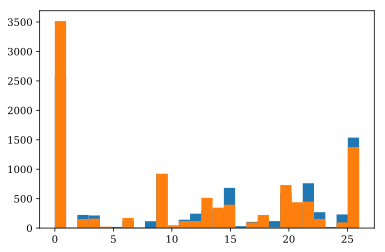

In [3]:
plt.hist(df['Correct'],bins = num_classes);
plt.hist(df['Predicted'],bins = num_classes)

In [4]:
def EceEval(confidence, y, num_bins=10):
    bins = np.linspace(0, 1, num_bins+1)
    digitized = np.digitize(confidence, bins[1:-1])
    
    w = np.array([(digitized==i).sum() for i in range(num_bins)])
    w = w/sum(w)

    confidence_bins = np.array([confidence[digitized==i].mean() for i in range(num_bins)])
    accuracy_bins = np.array([y[digitized==i].mean() for i in range(num_bins)])
    confidence_bins[np.isnan(confidence_bins)] = 0
    accuracy_bins[np.isnan(accuracy_bins)] = 0
    diff = np.absolute(confidence_bins - accuracy_bins)
    ece = np.inner(diff,w)
    return ece

In [5]:
column_names = ['Predicted_Class_k', 'R_k', 'N_k','Acc_k', 'Conf_k', 'ECE_k', 'Calibration_Bias_k']
output_df = pd.DataFrame(np.zeros((num_classes,len(column_names))), columns = column_names) 

output_df['Predicted_Class_k'] = [id for id in range(num_classes)]
output_df['R_k'] = [df[(df['Correct']==id) & (df['Predicted']==id)].shape[0] for id in range(num_classes)]
output_df['N_k'] = [df[(df['Predicted']==id)].shape[0] for id in range(num_classes)]
output_df['Acc_k'] = output_df['R_k'] / output_df['N_k']
output_df['Conf_k'] = [df[(df['Predicted']==id)]['Confidence'].mean() for id in range(num_classes)]
output_df['Calibration_Bias_k'] = output_df['Conf_k'] - output_df['Acc_k']
for class_idx in range(num_classes):
    mask = (df['Predicted']==class_idx)
    confidence = df[mask]['Confidence']
    y = df[mask]['Correct'] == df[mask]['Predicted']
    output_df['ECE_k'][class_idx] = EceEval(confidence, y, num_bins=num_bins)
output_df.to_csv('jamia_hgru_128_output_df.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


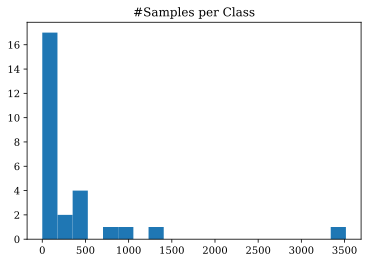

<Figure size 432x288 with 0 Axes>

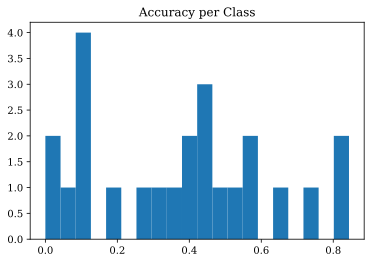

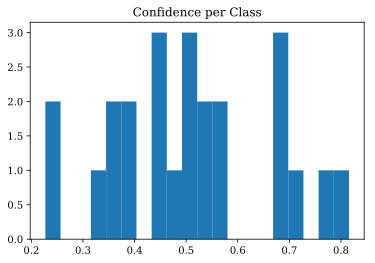

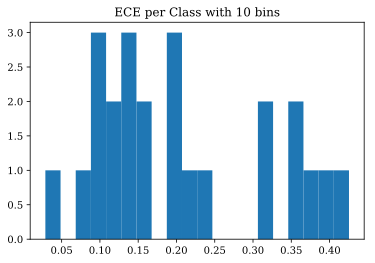

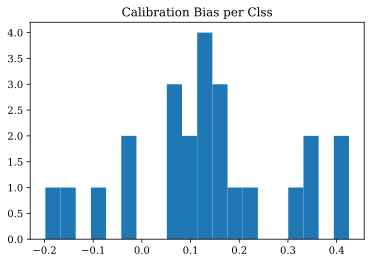

In [6]:
plt.figure();
plt.hist(output_df['N_k'],bins=20);
plt.title('#Samples per Class');
plt.figure();
plt.figure();
plt.hist(output_df['Acc_k'],bins=20);
plt.title('Accuracy per Class');
plt.figure();
plt.hist(output_df['Conf_k'],bins=20);
plt.title('Confidence per Class');
plt.figure();
plt.hist(output_df['ECE_k'],bins=20);
plt.title('ECE per Class with %d bins' % num_bins);
plt.figure();
plt.hist(output_df['Calibration_Bias_k'],bins=20);
plt.title('Calibration Bias per Clss');

In [7]:
# class with loweest accuracy
output_df.sort_values('Acc_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
1,1,0,11,0.000000,0.396686,0.396686,0.396686
7,7,0,1,0.000000,0.227166,0.227166,0.227166
14,14,29,347,0.083573,0.508978,0.425404,0.425404
17,17,9,95,0.094737,0.402347,0.307610,0.307610
11,11,12,121,0.099174,0.435425,0.357580,0.336252
19,19,2,20,0.100000,0.227127,0.192085,0.127127
10,10,5,48,0.104167,0.456317,0.353639,0.352150
5,5,1,5,0.200000,0.370969,0.371580,0.170969
18,18,58,222,0.261261,0.332657,0.100962,0.071395
25,25,32,97,0.329897,0.493761,0.163864,0.163864


In [8]:
# class with loweest calibration bias
output_df.sort_values('Calibration_Bias_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
15,15,285,397,0.717884,0.519578,0.198306,-0.198306
22,22,365,450,0.811111,0.673237,0.137874,-0.137874
12,12,51,119,0.428571,0.350157,0.100227,-0.078415
26,26,1161,1376,0.843750,0.815563,0.028729,-0.028187
4,4,12,24,0.500000,0.477351,0.224472,-0.022649
2,2,71,154,0.461039,0.521512,0.116430,0.060473
13,13,202,513,0.393762,0.454847,0.096476,0.061085
18,18,58,222,0.261261,0.332657,0.100962,0.071395
21,21,202,439,0.460137,0.545920,0.085783,0.085783
6,6,97,172,0.563953,0.673028,0.144918,0.109074


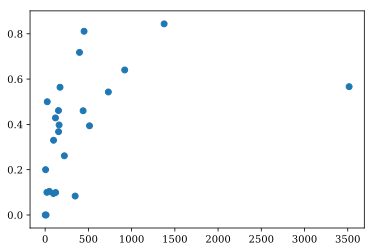

In [9]:
#plt.scatter(output_df['ECE_k'], output_df['Calibration_Bias_k']);
plt.scatter(output_df['N_k'], output_df['Acc_k'])